In [1]:
from pathlib import Path
import sys
sys.path.insert(1, 'C:\\Users\\ASUS\\Documents\\GitHub\\Big-data-mathematics')

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import random

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

from models.vae import Base, LMCVAE
from distributions.samplers import HMC, run_chain
from distributions.distributions import Funnel

import numpy as np

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

%matplotlib widget

In [8]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
n_steps = 1
dist = "funnel"
dim = 50
scale_proposal = 1.
scale_isir = 5.
dist_class = "Funnel"
dist_params = {
    "b": 0.02,
    "sigma":5.0,
}
sigma = 4
b = 0.02

In [11]:
# Данные
target = Funnel(
                dim=dim,
                device=device,
                b = b,
                sigma = sigma,
                #b = b
                #**dist_params.dict,
)

loc_proposal = torch.zeros(dim).to(device)
scale_proposal = scale_proposal * torch.ones(dim).to(device)
scale_isir = scale_isir * torch.ones(dim).to(device)

# proposal = IndependentNormal(
#     dim=dim,
#     loc=loc_proposal,
#     scale=scale_proposal,
#     device=device,
# )

# proposal_ex2 = IndependentNormal(
#     dim=dim,
#     loc=loc_proposal,
#     scale=scale_isir,
#     device=device,
# )

In [12]:
class Banana_Dataset(Dataset):
    def __init__(self, data):
        super(Banana_Dataset, self).__init__()
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        sample = torch.tensor(self.data[item], dtype=torch.float32, device=device)
        return sample, -1.

## Generate ground-truth samples

In [13]:
N_samples = 2*10**4
np.random.seed(42)
True_samples = np.random.randn(N_samples,dim)
for i in range(dim):
    if i % 2 == 0:
      True_samples[:,i] *= sigma
    else:
      True_samples[:,i] += b*True_samples[:,i-1]**2 - (sigma**2)*b

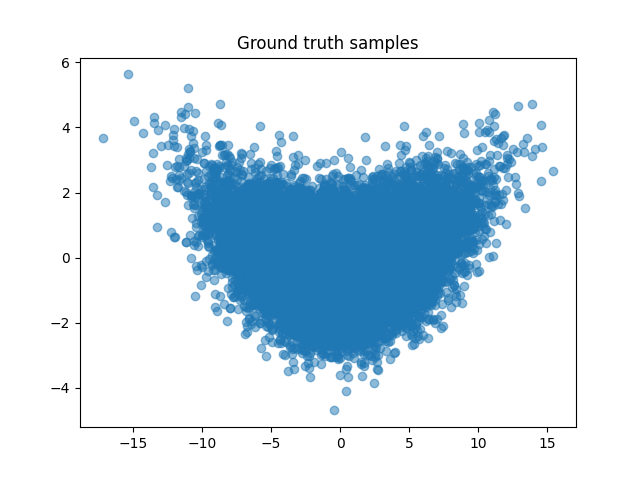

In [14]:
fig,ax=plt.subplots(1,1)
#cp = ax.contourf(X, Y, dens_vals)
#fig.colorbar(cp) # Add a colorbar to a plot
ax.scatter(True_samples[:,0],True_samples[:,1], alpha=0.5)
ax.set_title('Ground truth samples')
plt.show()